In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

dataset_path = "../dataset"
preprocessed_dataset_path = "../dataset/preprocessed_dataset"

from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

In [2]:
european_volumetric_dataset_term = pd.read_csv('../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [3]:
european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

`european_volumetric_dataset_term` has 279 observations (after removal of low image quality and radiology score)

In [50]:
tract_volumes = pd.read_csv('../codes/FBA/output/aba/wm_parcellation_volume.txt',delim_whitespace=True,header=None)

In [51]:
tract_volumes = tract_volumes.iloc[:,np.r_[[0]+[i for i in range(94,148)]]]
tract_volumes.columns = ['ID/Ses']+[f'l_{i}' for i in range(94,148)]

In [52]:
df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

In [53]:
df = stats.MassUnivariate.remove_outliers(
    df,
    col=['WM','GM','TBV','ICV'],
    threshold=3.5,
    remove_schemes='any')

In [6]:
fd_mean = pd.read_csv('../codes/FBA/output/aba/mean_fa.txt',delim_whitespace=True,header=None,
                     names=['ID/Ses']+[f'l_{i}' for i in range(94,148)])

In [54]:
df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

In [9]:
fd_mean.shape

(229, 55)

In [10]:
fd_mean = pd.merge(df,fd_mean,on=['ID/Ses'])

In [55]:
tract_volumes = pd.merge(df,tract_volumes,on=['ID/Ses'])

In [56]:
tract_volumes = tract_volumes.drop_duplicates(subset=['ID/Ses'])

In [58]:
tract_volumes = tract_volumes.dropna(subset=['l_94'])

In [75]:
pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    tract_volumes,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)

tract_volumes['PRS_pca'] = prs_pca

/tmp/ipykernel_884251/2115912514.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_volumes['PRS_pca'] = prs_pca


In [88]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    tract_volumes,
    thresholds=[i for i in tract_volumes.columns if 'ASD_PRS' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[f'l_{i}' for i in range(94,148)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.00s/it]


In [89]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(tract_volumes[[f'l_{i}' for i in range(94,148)]],rowvar=False))

Effective Number of Independent Variables [Veff] is 29.588147823710116
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 17.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.002941176470588242


16.99999999999996

In [82]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(tract_volumes[[i for i in tract_volumes.columns if 'SCZ_PRS' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 5.110944751786361
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 4.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.01250000000000001


3.9999999999999973

In [91]:
0.05/17/6

0.0004901960784313725

<AxesSubplot:xlabel='standardize(Adj. l_102)', ylabel='standardize(Adj. PRS_pca)'>

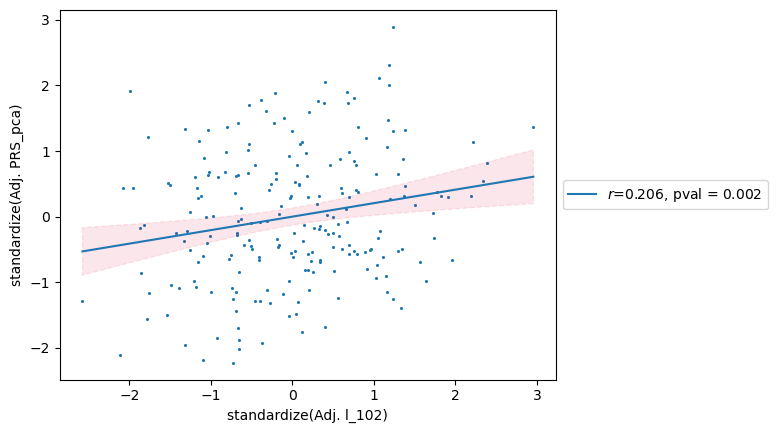

In [80]:
visualisation.SimplePlots.Scatter(x='l_102',y='PRS_pca',data=tract_volumes,adjust_covar={'x':['GA','PMA','sex','TBV'],'y':ancestry})

In [90]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
327,l_97,514.466991,4.976418e-225,-6.291478,0.179247,2.212935,0.428374,9.130521,0.026913,52.545261,7.543391e-35,1.642909,0.441354,1.177829,0.574092,-0.055334,0.979240,8.954820,0.000028,ASD_PRS_Pt_0.01
332,l_102,2987.718294,1.942696e-240,-16.061297,0.483351,19.144025,0.162650,-45.497369,0.024442,360.415736,3.146476e-53,5.550795,0.595327,-1.546457,0.880235,4.685809,0.652962,37.693239,0.000295,ASD_PRS_Pt_0.01
333,l_103,2896.927625,3.065462e-239,22.961927,0.308085,14.908968,0.268008,-31.151091,0.115742,356.746789,1.092957e-53,-2.541757,0.804439,4.152610,0.680543,-4.845537,0.636038,34.447102,0.000742,ASD_PRS_Pt_0.01
326,l_96,471.511395,1.599301e-217,-5.723582,0.219662,-2.678960,0.335822,14.241777,0.000587,44.681934,5.796623e-28,0.555533,0.793632,-1.317438,0.527885,-4.726777,0.026483,6.801581,0.001265,ASD_PRS_Pt_0.01
386,l_102,2987.467214,1.331239e-239,-15.556834,0.501187,13.234524,0.332577,-38.435339,0.056707,356.167365,2.792135e-52,6.204634,0.557588,-2.312677,0.823614,7.766524,0.458414,31.698876,0.002180,ASD_PRS_Pt_0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,l_134,415.141047,3.243594e-182,-8.330407,0.170190,4.761627,0.185870,21.248028,0.000080,36.772043,4.769430e-14,-2.311419,0.405920,0.120848,0.964813,0.633530,0.818857,0.035309,0.989583,ASD_PRS_Pt_0.1
453,l_115,324.817777,2.140075e-170,6.933778,0.201101,3.517972,0.273570,-15.821825,0.000942,38.749688,3.723964e-18,2.924984,0.239437,2.248946,0.358553,0.948325,0.701180,0.027518,0.990911,ASD_PRS_Pt_0.1
419,l_135,435.119466,9.037472e-186,-8.775579,0.152129,2.051052,0.569862,19.940191,0.000221,39.920396,8.173964e-16,-1.847939,0.509005,-0.202863,0.941058,-0.191337,0.944894,-0.030520,0.990997,ASD_PRS_Pt_0.05
146,l_132,204.424027,5.902766e-188,-5.320981,0.058659,3.513588,0.034972,1.805981,0.457770,17.211267,2.134129e-14,-1.189378,0.351629,-0.394766,0.753074,0.179853,0.887886,-0.012479,0.991942,ASD_PRS_Pt_1e-06


In [9]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    fd_mean,
    thresholds=[i for i in fd_mean.columns if 'ASD_PRS' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA']+ancestry,
    dependentVar_cols=[f'l_{i}' for i in range(94,148)])

100%|███████████████████████████████████████████| 11/11 [00:09<00:00,  1.11it/s]


In [12]:
test.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
80,l_120,0.259224,4.735118e-200,-0.003638,0.218000,-0.002256,0.234934,0.018182,4.345872e-18,0.001481,0.325996,-0.001884,0.209613,0.000140,0.926895,0.004300,0.003914,ASD_PRS_Pt_1e-07
441,l_103,0.261484,8.708963e-203,-0.009644,0.000953,0.003041,0.103204,0.012681,1.345084e-10,0.000494,0.739352,-0.002185,0.140839,-0.001520,0.310121,0.004243,0.004047,ASD_PRS_Pt_0.1
511,l_119,0.227801,8.484606e-216,-0.002683,0.217963,0.003784,0.007506,0.007153,1.077239e-06,-0.000995,0.373081,-0.002257,0.044975,0.000443,0.695125,0.003052,0.006336,ASD_PRS_Pt_0.5
565,l_119,0.227804,8.745662e-216,-0.002691,0.216702,0.003810,0.007149,0.007126,1.207199e-06,-0.000949,0.396201,-0.002236,0.046790,0.000428,0.705040,0.003044,0.006591,ASD_PRS_Pt_1
26,l_120,0.259236,9.265846e-200,-0.003663,0.216554,-0.002847,0.136756,0.018261,4.104138e-18,0.001470,0.330988,-0.002189,0.146851,0.000127,0.933976,0.004004,0.007650,ASD_PRS_Pt_1e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,l_126,0.202799,2.781590e-145,-0.002595,0.541846,0.001430,0.602583,0.016240,2.038265e-08,0.002212,0.311522,-0.002775,0.206104,0.000719,0.745188,0.000039,0.985689,ASD_PRS_Pt_0.5
78,l_118,0.240940,3.353366e-218,-0.000628,0.779516,0.002744,0.058139,0.009452,5.664322e-10,0.000101,0.929751,-0.001524,0.182313,-0.000547,0.637035,0.000017,0.988012,ASD_PRS_Pt_1e-07
61,l_101,0.178422,5.355182e-147,-0.008827,0.017034,-0.001865,0.430310,0.027965,7.933445e-25,0.000210,0.910931,-0.002756,0.141286,0.001753,0.356442,-0.000020,0.991248,ASD_PRS_Pt_1e-07
498,l_106,0.208184,1.042988e-165,-0.000319,0.926639,0.003001,0.180654,-0.004072,7.415675e-02,-0.001744,0.327456,-0.001683,0.346445,-0.002073,0.250553,-0.000009,0.995723,ASD_PRS_Pt_0.5


In [18]:
set(test[test['PRS_pval']<0.05].Connection.unique())

{'l_103',
 'l_107',
 'l_110',
 'l_115',
 'l_117',
 'l_118',
 'l_119',
 'l_120',
 'l_122',
 'l_129',
 'l_132',
 'l_133',
 'l_134',
 'l_135',
 'l_136',
 'l_140',
 'l_143',
 'l_94',
 'l_96',
 'l_97'}

In [ ]:
t

In [308]:
test = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    fd_mean,
    thresholds=[i for i in fd_mean.columns if 'SCZ_PRS' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA']+ancestry,
    dependentVar_cols=['l_111'])

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 42.09it/s]


Text(0.5, 1.0, 'Right Fornix MD ~ SCZ PRS')

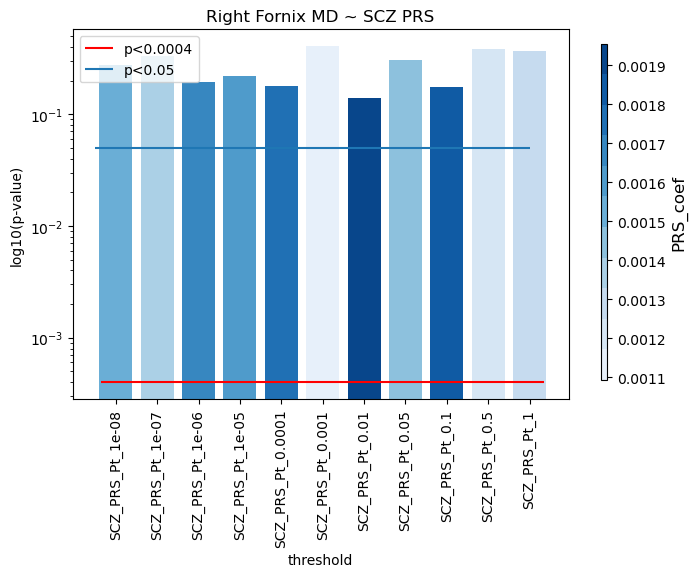

In [309]:
fig,ax = plt.subplots(1,1)
visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',
                              data=test,
                              yscalelog=True,order={'x':[i for i in fd_mean.columns if 'SCZ_PRS' in i]},
                              colorby='PRS_coef',cmap='Blues',rotation_x=90,hline=0.0004,hline_label='p<0.0004',legend_loc='upper right',ax=ax,fig=fig,
                             ylabel='log10(p-value)')
ax.hlines(0.05,xmin=0.5,xmax=11,label='p<0.05')
ax.legend(['p<0.0004','p<0.05'],loc='upper left')
ax.set_title('Right Fornix MD ~ SCZ PRS')

<AxesSubplot:xlabel='standardize(Adj. Fornix R. FA)', ylabel='standardize(Adj. SCZ_PRS_Pt_0.5)'>

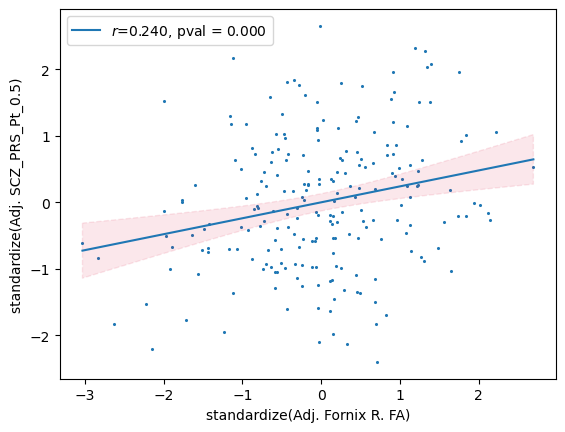

In [333]:
visualisation.SimplePlots.Scatter(x='l_111',
                                  y='SCZ_PRS_Pt_0.5',
                                  adjust_covar={'x':['GA','PMA','sex'],'y':ancestry},
                                  data=fd_mean,xlabel='Fornix R. FA',legend_loc='upper left')

In [72]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(fd_mean[[f'l_{i}' for i in range(94,148)]],rowvar=False))

Effective Number of Independent Variables [Veff] is 43.51634360884992
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 26.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0019230769230769227


26.000000000000007

In [73]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(fd_mean[[i for i in fd_mean.columns if 'SCZ_PRS' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 5.110944751786361
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 4.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.01250000000000001


3.9999999999999973

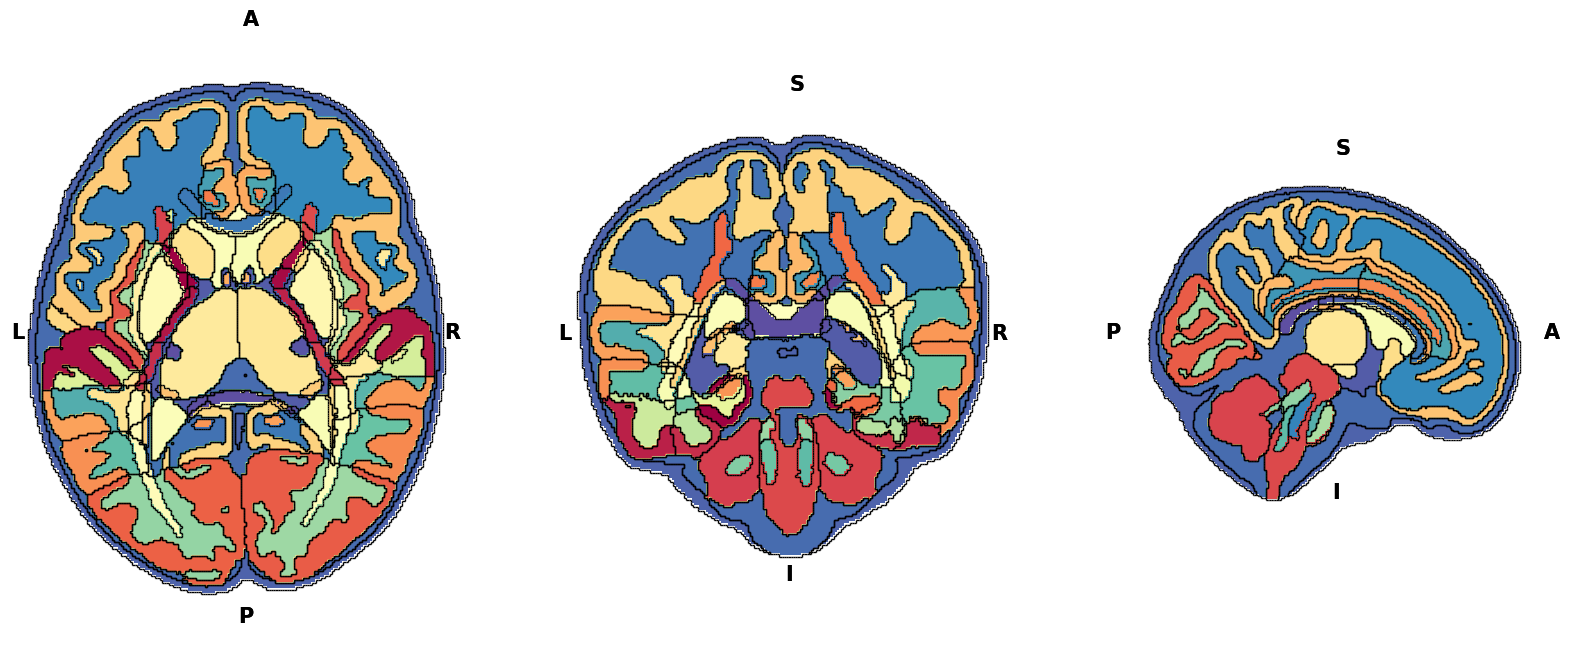

In [104]:
fig,ax = plt.subplots(1,3,figsize=(20,10))
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../codes/FBA/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    
    axes=ax)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../codes/FBA/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    axes=ax)

In [ ]:
ax